In [1]:
import torch
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from utils.plots import plot_pca, optimal_cluster_plot, plot_first3PCA
import os, sys
sys.path.append(r'C:\Users\sebas\RU\RBM')
from PGM.utilities import RBM_utils
from boltzmann_machines.RTRBM_ import RTRBM
from data.reshape_data import reshape

C:\Users\sebas\RU\RBM\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
C:\Users\sebas\RU\RBM\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


In [3]:
file = h5py.File(open(r'C:\Users\sebas\RU\RBM\crbm_zebrafish_spontaneous_data\neural_recordings\full_calcium_data_sets\20180912_Run01_spontaneous_rbm2.h5','rb'))
print(file['Data']['Brain'].keys())
spike_idx = np.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\cRBM Jerome+Thijs\crbm_zebrafish_spontaneous_data\neural_recordings\full_spike-only_data_sets\spike_idx.npy')
coordinates = np.transpose(np.array(file['Data']['Brain']['Coordinates']))[spike_idx, :]

<KeysViewHDF5 ['Analysis', 'Coordinates', 'LJPCoordinates', 'Labels', 'Pixels', 'RawSignal', 'TimeDelays', 'Times', 'ZBrainCoordinates']>


In [2]:
rbm = RBM_utils.loadRBM(r'C:\Users\sebas\RU\RBM\crbm_zebrafish_spontaneous_data\example_cRBM\RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M200_l1-2e-02_duration208093s_timestamp2020-05-16-0844.data')
rtrbm = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\full brain\Sparse penalty\tranfer_whole_brain_rtrbm_sp_0_n_100')
# rtrbm = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\full brain\thijs_weights_rtrbm_lr1e-3_epo10000.pt')
W = rtrbm.W.cpu()
U = rtrbm.U.cpu()

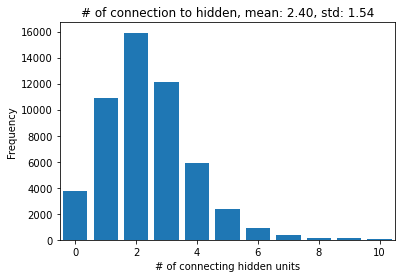

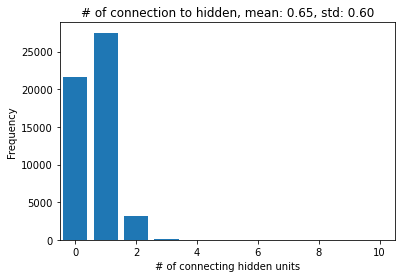

In [8]:

th=0.1
n_connections = np.sum(1.0 * (np.abs(rbm.weights)>th), 0)
n_connections = n_connections[n_connections<40]
n_con, freq = np.unique(n_connections, return_counts=True)
plt.bar(n_con, freq)
# sns.kdeplot(n_connections)
plt.title('# of connection to hidden, mean: %.4s, std: %.4s'%(float(np.mean(n_connections)), float(np.std(n_connections))))
plt.xlabel('# of connecting hidden units')
plt.ylabel('Frequency')
plt.xlim([-0.5, 10.5])
plt.show()

th=0.6
n_connections = torch.sum(1.0 * (torch.abs(W)>th), 0)
n_connections = n_connections[n_connections<40]
n_con, freq = torch.unique(n_connections, return_counts=True)
plt.bar(n_con, freq)
# sns.kdeplot(n_connections)
plt.title('# of connection to hidden, mean: %.4s, std: %.4s'%(float(torch.mean(n_connections)), float(torch.std(n_connections))))
plt.xlabel('# of connecting hidden units')
plt.ylabel('Frequency')
plt.xlim([-0.5, 10.5])
plt.show()

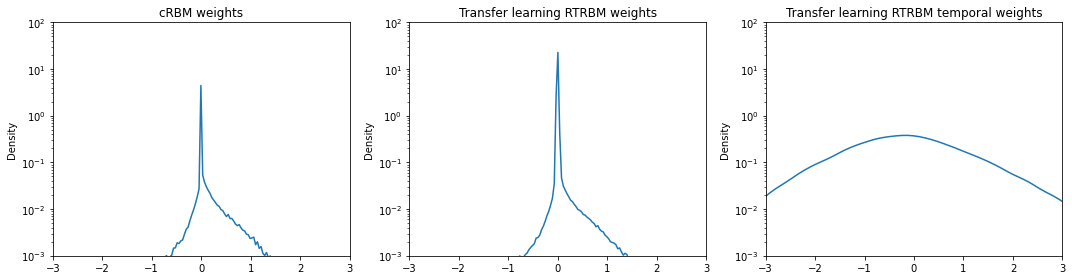

C:\Users\sebas\anaconda3\envs\RTRBM\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


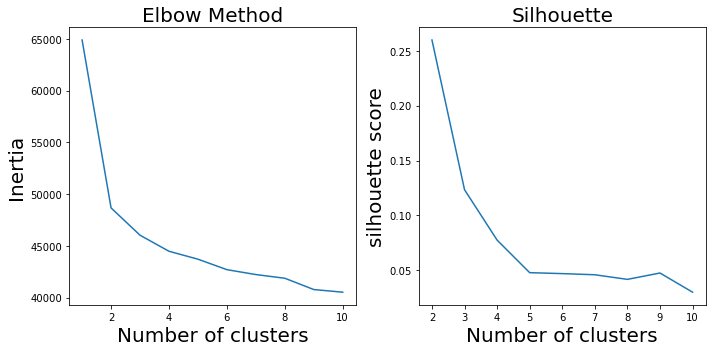

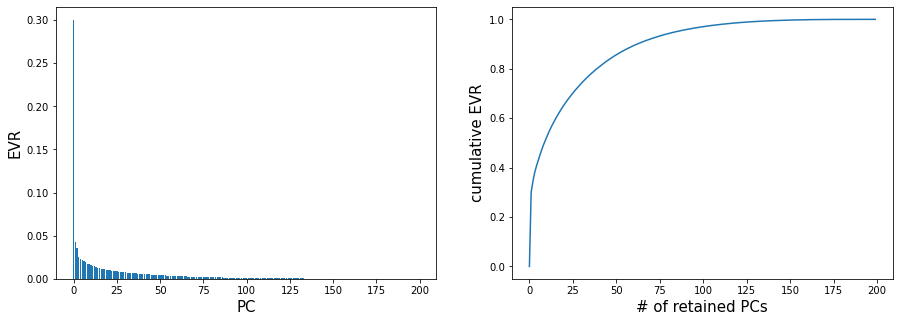

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.kdeplot(rbm.weights.ravel(), log_scale=[0, 10], ax=ax[0])
ax[0].set_ylim([1e-3, 1e2])
ax[0].set_xlim([-3, 3])
ax[0].set_title('cRBM weights')

sns.kdeplot(rtrbm.W.ravel().cpu(), log_scale=[0, 10],ax=ax[1])
ax[1].set_ylim([1e-3, 1e2])
ax[1].set_xlim([-3, 3])
ax[1].set_title('Transfer learning RTRBM weights')

sns.kdeplot(rtrbm.U.cpu().ravel(), log_scale=[0, 10],ax=ax[2])
ax[2].set_ylim([1e-3, 1e2])
ax[2].set_xlim([-3, 3])
ax[2].set_title('Transfer learning RTRBM temporal weights')
plt.tight_layout()
plt.show()

optimal_cluster_plot(U)
plot_pca(U)

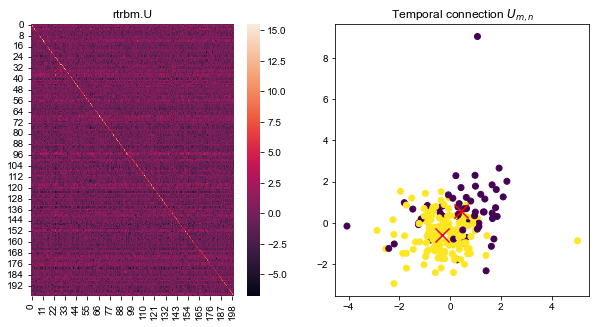

C:\Users\sebas\RU\intern\utils\plots.py:649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labels == 'None':


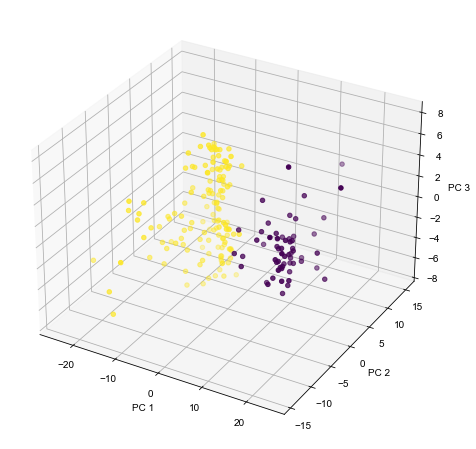

In [31]:
kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(U)
labels =  kmeans.labels_
centers = kmeans.cluster_centers_

fig, ax = plt.subplots(1,2, figsize=(10,5))

# ax[0].imshow(U, aspect='equal', cmap=plt.get_cmap('bwr'), vmin=-1.5, vmax=1.5)
sns.heatmap(U, ax=ax[0])
ax[0].set_title("rtrbm.U")

ax[1].set_title("Temporal connection $U_{m,n}$")
ax[1].scatter(U[:, 0], U[:, 1], c=labels)
ax[1].scatter(centers[:,0],centers[:,1], marker='x', c="r",s=200)
plt.show()

plot_first3PCA(U, labels = labels)

<AxesSubplot:>

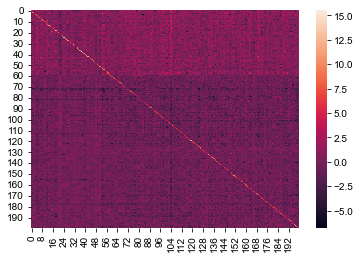

In [57]:
idx_U_sorted = np.argsort(kmeans.fit_predict(U))
U_ = U[idx_U_sorted, :].detach()
U_ = U_[:, idx_U_sorted]
W_ = W[idx_U_sorted, :].detach()
sns.heatmap(U_)


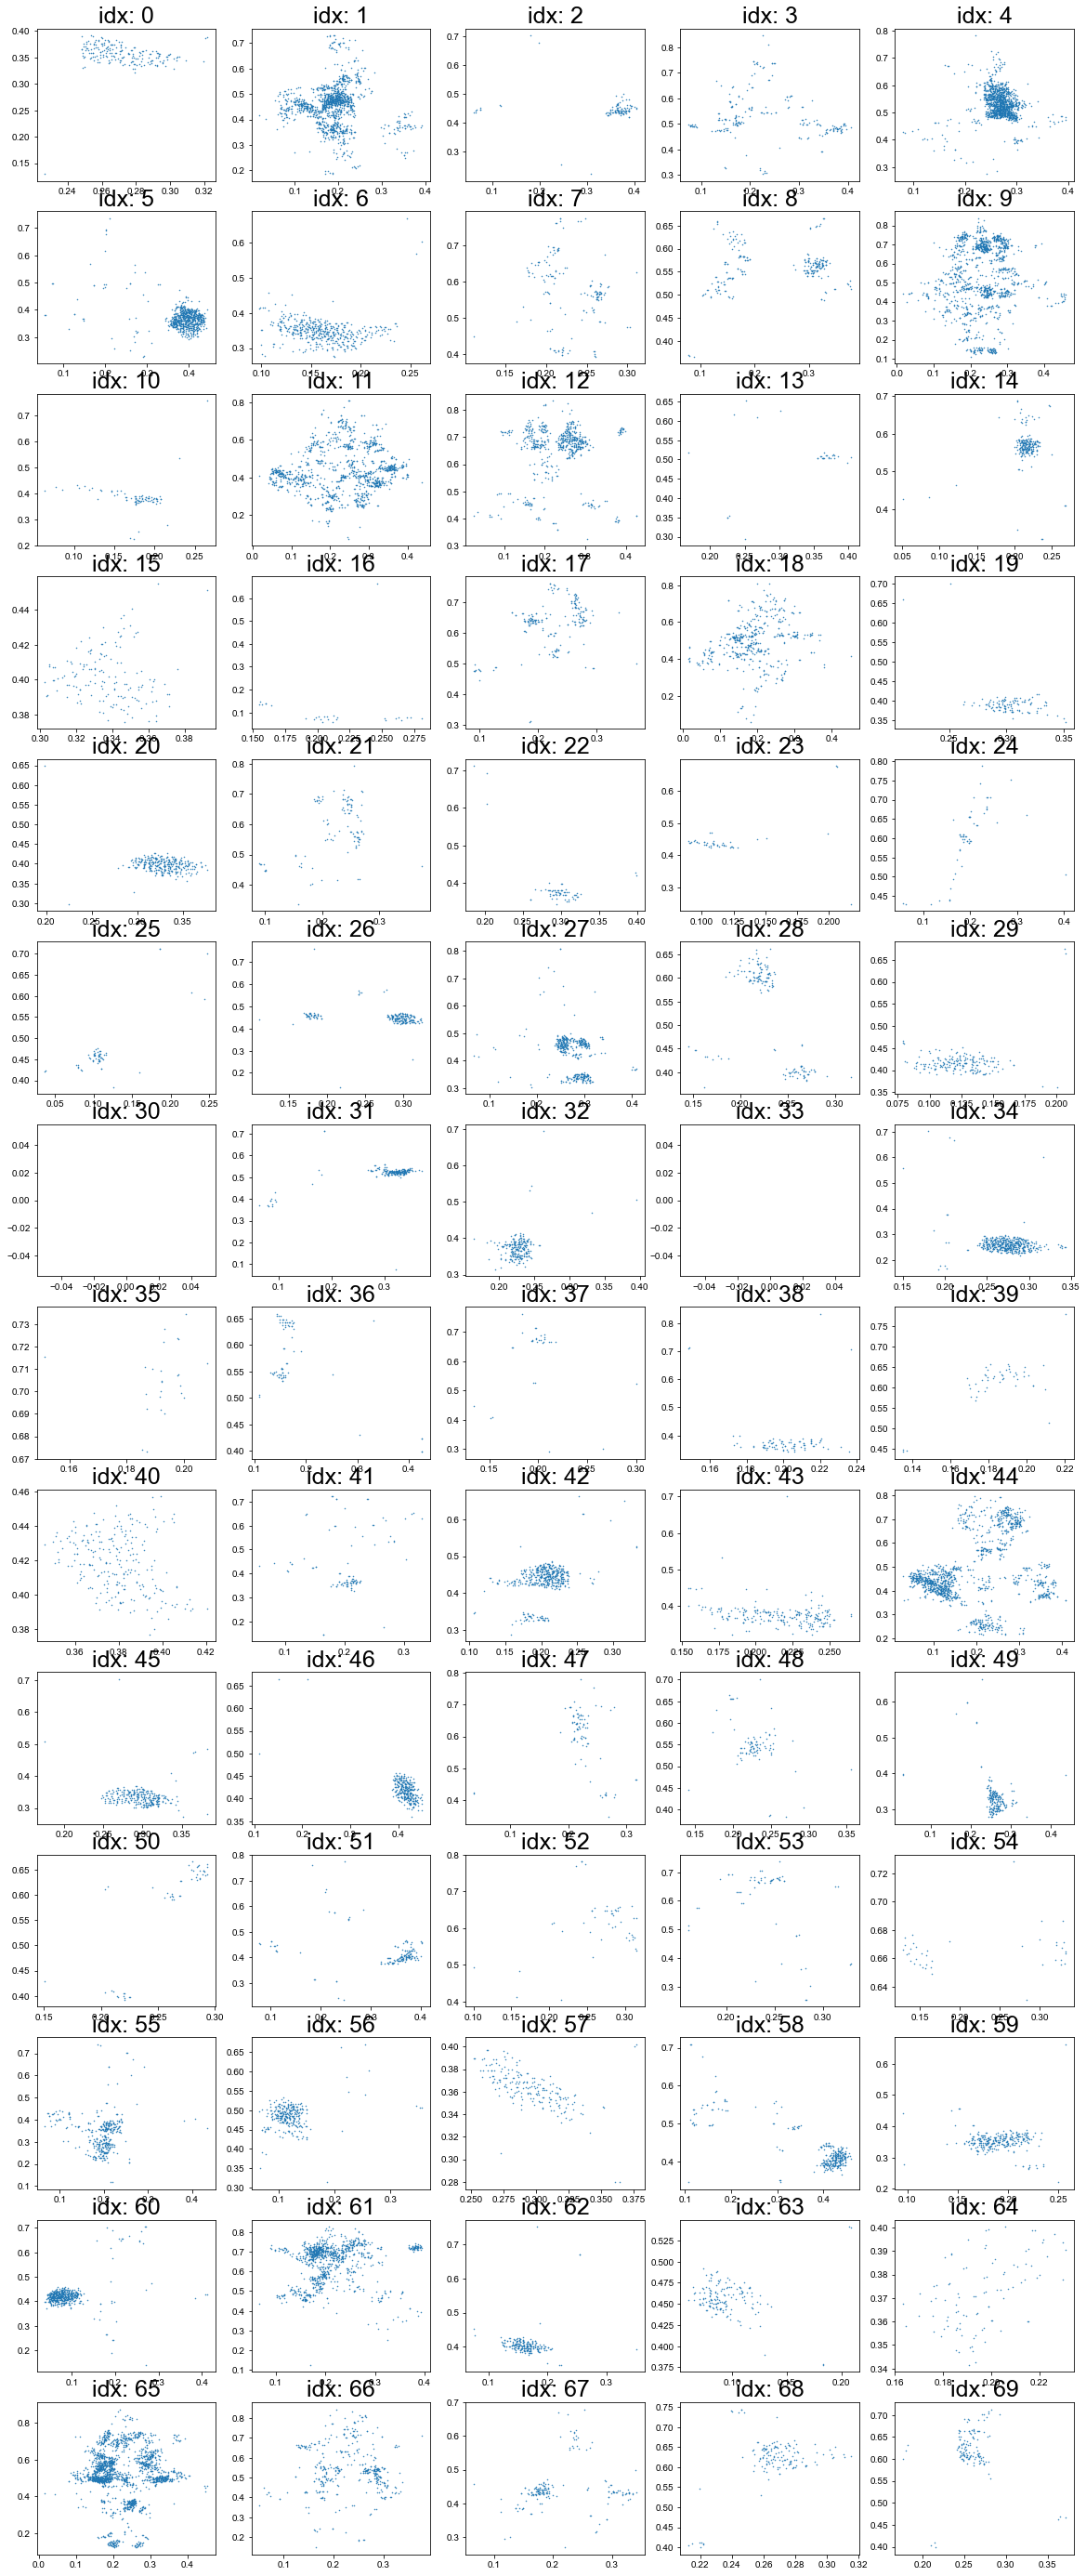

In [58]:
th=0.245
fig, axes = plt.subplots(14, 5, figsize=(20, 50))

for i, ax in enumerate(axes.flatten()):
    RF_hi = coordinates[torch.where((torch.abs(W_[i, :])>th))[0], :]
    ax.plot(RF_hi[:, 0], RF_hi[:, 1], '.', ms=1)
    ax.set_title('idx: '+str(i), fontsize=25)

In [13]:
U_sorted = [0, 18, 19, 32, 33, 42, 53]
    #[34, 17, 21, 26, 0, 4, 18, 19, 24, 32, 33, 35, 36, 42, 44, 64, 53]

<AxesSubplot:>

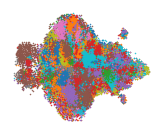

In [14]:
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS)

path2dir = (r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\figures\Paper Figures\Figure 3')
# hv, h{t}, h_{t-1}

it_color = 0

strongest_connections = np.argmax(np.abs(W_), 0)
fig, ax = plt.subplots(1,1, figsize=(8.27/3.5, 11.69/6))

for i in range(200): # 200 hiddens units
    color=colors[it_color]
    it_color+=1
    if i % 10 == 0:
        it_color = 0

    RF_hi = coordinates[torch.where((torch.abs(W_[i, :])>th))[0], :]
    #idx = coordinates[np.where(strongest_connections==h), :]
    ax.plot(RF_hi[:, 1], RF_hi[:, 0], '.', ms=1, color=color)

for i, h in enumerate(U_sorted[::-1]): # 200 hiddens units
    color=colors[it_color]
    it_color+=1
    if i % 10 == 0:
        it_color = 0
    RF_hi = coordinates[torch.where((torch.abs(W_[h, :])>th))[0], :]
    #idx = coordinates[np.where(strongest_connections==h), :]
    ax.plot(RF_hi[:, 1], RF_hi[:, 0], '.', ms=1, color=color)
ax.axis('off')
plt.tight_layout()
plt.gca()
#plt.savefig(path2dir + '\Whole_brain_with_RF.png', orientation = 'portrait', format = 'png', dpi=1000, bbox_inches = "tight", transparent=True)

<AxesSubplot:>

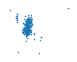

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8.27/3.5/2, 11.69/6/2))
#for i, h in enumerate(U_sorted[0]): # 200 hiddens units
i=0
h=U_sorted[5]
color=colors[0]

RF_hi = coordinates[torch.where((torch.abs(W_[h, :])>th))[0], :]
#idx = coordinates[np.where(strongest_connections==h), :]
ax.plot(RF_hi[:, 1], RF_hi[:, 0], '.', ms=1, color=color)
ax.axis('off')

plt.tight_layout()
plt.gca()
#plt.savefig(path2dir + '\Individual_RF_1.png', orientation = 'portrait', format = 'png', dpi=1000, bbox_inches = "tight", transparent=True)

In [16]:
#from utils.plots import *
#plot_mean_std_param_history(rtrbm.parameter_history)
# HU_RF_fig_idx = [0, 19, 42]
# U_sub = U_[HU_RF_fig_idx, :].detach()
# U_sub = U_sub[:, HU_RF_fig_idx]
# sns.heatmap(U_sub)
#plt.imshow(U_sub, aspect='equal', cmap=plt.get_cmap('bwr'), vmin=-3, vmax=3)

Moments plot of the cRBM & RTRBM

In [49]:
train_list, test_list = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\cRBM Jerome+Thijs\crbm_zebrafish_spontaneous_data\train_test_list')
test = test_list[1]
print(test.shape)

for i in range(1, 556):
    if (555 % i) == 0:
        print(i)

torch.Size([52518, 15, 45])
1
3
5
15
37
111
185
555


In [50]:
3885/15


259.0

In [21]:
W.shape

torch.Size([200, 52518])

In [22]:
Lchains = 15 # Length of MCMC chains
Nchains = 259 # Number of MCMC chains
Nsteps = 20 # Number of steps between saved MCMC points
Nthermalize = 4000 # Number of burn-in MCMC steps

vs, hs = rbm.gen_data(Lchains=Lchains,
                                    Nchains=Nchains,
                                    Nthermalize=Nthermalize,
                                    Nstep = Nsteps) # Generate RBM samples by MCMC

vs, hs = vs.T, hs.T
vt = np.array(test)

  0%|          | 1/4000 [00:00<09:57,  6.69it/s]

Mismatch dimensions (100, 200), [259, 200], reinitializating I
Mismatch dimensions (100, 52518), [259, 52518], reinitializating I


100%|██████████| 14/14 [00:42<00:00,  3.05s/it]


In [3]:
[vs, hs] = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\full brain\cRBM infer\vs_hs')

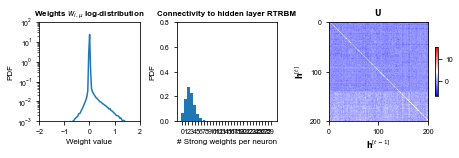

In [54]:
plt.rcParams["font.family"] = "Arial"

fig, axes = plt.subplots(1, 3, figsize=(6.3, 2), gridspec_kw={'width_ratios': [.7, .7, 1]})

sns.kdeplot(rtrbm.W.ravel().cpu(), log_scale=[0, 10], ax=axes[0])
axes[0].set_xlim([-2, 2])
axes[0].set_ylim([1e-3, 1e2])
axes[0].set_title(r'Weights $w_{i, \mu}$ log-distribution', fontsize=8, fontweight='bold')
axes[0].set_xlabel('Weight value', fontsize=8)
axes[0].set_ylabel('PDF', fontsize=8)
axes[0].tick_params(axis='both', which='major', labelsize=7)

threshold = .1
strong_connections = torch.sum(torch.abs(rtrbm.W.cpu()) > threshold, 0)
n_strong_conn, counts = np.unique(strong_connections, return_counts=True)
axes[1].bar(n_strong_conn, counts / np.sum(counts))
axes[1].set_title('Connectivity to hidden layer RTRBM', fontsize=8, fontweight='bold')
axes[1].set_xlabel('# Strong weights per neuron', fontsize=8)
axes[1].set_ylabel('PDF', fontsize=8)
axes[1].tick_params(axis='both', which='major', labelsize=7)
axes[1].set_xticks(np.arange(np.max(n_strong_conn + 1)))
axes[1].set_xticklabels(np.arange(np.max(n_strong_conn + 1)))
axes[1].set_ylim(0, .8)

cm = axes[2].imshow(U_, plt.get_cmap('bwr'), aspect='equal')
cb = fig.colorbar(cm, ax=axes[2], shrink=.5)
cb.ax.tick_params(axis='both', which='major', labelsize=7)
axes[2].set_xlabel(r'$\mathbf{h}^{[t-1]}$', fontsize=8)
axes[2].set_ylabel(r'$\mathbf{h}^{[t]}$', fontsize=8)
axes[2].set_title(r'$\mathbf{U}$', fontsize=8)
axes[2].set_xticks([0, 100, 200])
axes[2].set_xticklabels([0, 100, 200], fontsize=7)
axes[2].set_yticks([0, 100, 200])
axes[2].set_yticklabels([0, 100, 200], fontsize=7)

plt.tight_layout(pad=.2, w_pad=.2, h_pad=.2)
#plt.savefig(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\figures\Paper Figures\Figure 3\Temp_seb\weights_stats.png', dpi=1000)
plt.show()

In [51]:
from utils.moments_plot import infer_and_get_moments_plot
dir2rtrbm = r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\full brain\Sparse penalty\tranfer_whole_brain_rtrbm_sp_0_n_100'
[vt_rtrbm, vs_rtrbm, ht_rtrbm, hs_rtrbm], [r2v, r2v2, r2h, r2h2, r2vh] = infer_and_get_moments_plot(dir=dir2rtrbm, test=test, plot=False, machine='rtrbm_parallel')

100%|██████████| 45/45 [00:00<00:00, 44747.20it/s]


In [62]:
vt_rtrbm.shape

torch.Size([52518, 675])

In [5]:
batch_size=100
verbose=1
v = np.array(vs.T, dtype=np.int64)
t=0
nTime,nNeurons = v.shape
nbatches = int(np.ceil(nTime/batch_size ))
pairwise = np.zeros([nNeurons,nNeurons],dtype=np.int64)
for b in range(nbatches):
    mini = b*nbatches
    maxi = min((b+1)*nbatches, len(v-t))
    pairwise += np.dot(1*v[mini:maxi].T,v[mini:maxi])
    if verbose:
        if b%10==0:
            print('Calculate <vv>, Batch %s/%s' %(b,nbatches))

Calculate <vv>, Batch 0/39
Calculate <vv>, Batch 10/39
Calculate <vv>, Batch 20/39
Calculate <vv>, Batch 30/39


In [10]:
torch.save(pairwise, r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\full brain\cRBM infer\pairwise_vs')

MemoryError: 

In [ ]:
k = torch.load(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\full brain\cRBM infer\pairwise_vs')
k.shape

In [52]:
def calculate_pairwise(v, t=0, batch_size=100,verbose=1):
    '''
    This utility calculates np.dot(v_data.T,v_data)/len(v_data)
    Although it shound not be necessary, using mini-batches seems to improve speed...

    '''
    nTime,nNeurons = v.shape
    nbatches = int(np.ceil(nTime/batch_size ))
    pairwise = np.zeros([nNeurons,nNeurons],dtype=np.int64)
    for b in range(nbatches):
        mini = b*nbatches
        maxi = min((b+1)*nbatches, len(v-t))
        pairwise += np.dot(1*v[mini:maxi].T,v[mini:maxi])
        if verbose:
            if b%10==0:
                print('Calculate <vv>, Batch %s/%s' %(b,nbatches) )
    return pairwise.astype(np.float32)/nTime

vvt = calculate_pairwise(vt_rtrbm)

In [ ]:
n_v_idx = np.random.permutation(vs.shape[0])[:10000]

vs_sub = np.array(vs[n_v_idx, :])
vt_sub = np.array(vt[n_v_idx, :])

vvt = (np.matmul(vt_sub, vt_sub.T) / vt_sub.shape[0]).flatten()
vvs = (np.matmul(vs_sub, vs_sub.T) / vs_sub.shape[0]).flatten()
vtvtm = (np.matmul(vt_sub[:, :-1], vt_sub[:, 1:].T) / vt_sub.shape[0]).flatten()
vsvsm = (np.matmul(vs_sub[:, :-1], vs_sub[:, 1:].T) / vs_sub.shape[0]).flatten()
idx = torch.randperm(vvt.shape[0])[:50000]
covt = vvt - np.matmul(np.mean(vt_sub, 1)[:, None], np.mean(vt_sub, 1)[None, :]).flatten()
covs = vvs - np.matmul(np.mean(vs_sub, 1)[:, None], np.mean(vs_sub, 1)[None, :]).flatten()
covt = covt[idx]
covs = covs[idx]
vvt = vvt[idx]
vvs = vvs[idx]
vtvtm = vtvtm[idx]
vsvsm = vsvsm[idx]


vs_sub_rtrbm = np.array(vs_rtrbm[n_v_idx, :])
vt_sub_rtrbm = np.array(vt_rtrbm[n_v_idx, :])

vvt_rtrbm = (np.matmul(vt_sub_rtrbm, vt_sub_rtrbm.T) / vt_sub_rtrbm.shape[0]).flatten()
vvs_rtrbm = (np.matmul(vs_sub_rtrbm, vs_sub_rtrbm.T) / vs_sub_rtrbm.shape[0]).flatten()
vtvtm_rtrbm = (np.matmul(vt_sub_rtrbm[:, :-1], vt_sub_rtrbm[:, 1:].T) / vt_sub_rtrbm.shape[0]).flatten()
vsvsm_rtrbm = (np.matmul(vs_sub_rtrbm[:, :-1], vs_sub_rtrbm[:, 1:].T) / vs_sub_rtrbm.shape[0]).flatten()
#idx = torch.randperm(vvt.shape[0])[:50000]
covt_rtrbm = vvt_rtrbm - np.matmul(np.mean(vt_sub_rtrbm, 1)[:, None], np.mean(vt_sub_rtrbm, 1)[None, :]).flatten()
covs_rtrbm = vvs_rtrbm - np.matmul(np.mean(vs_sub_rtrbm, 1)[:, None], np.mean(vs_sub_rtrbm, 1)[None, :]).flatten()
covt_rtrbm = covt_rtrbm[idx]
covs_rtrbm = covs_rtrbm[idx]
vvt_rtrbm = vvt_rtrbm[idx]
vvs_rtrbm = vvs_rtrbm[idx]
vtvtm_rtrbm = vtvtm_rtrbm[idx]
vsvsm_rtrbm = vsvsm_rtrbm[idx]

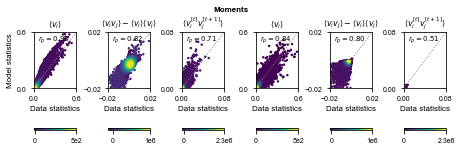

In [53]:
from scipy.interpolate import interpn
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.stats import pearsonr

def density_scatter(x, y, ax=None, fig=None, r=None, sort=True, bins=20, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()

    x[np.isnan(x)] = 0
    y[np.isnan(y)] = 0
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x, y]).T,
                method="splinef2d", bounds_error=False)

    # To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, s=2, **kwargs )

    norm = Normalize(vmin=np.min(z), vmax=np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm), ax=ax, ticks=[np.min(z), np.max(z)], orientation='horizontal', pad=0.35)
    cbar.ax.set_ylabel('Density', fontsize=8)
    cbar.ax.set_xticks([0, np.max(z)])
    # ax.plot([0, 1], [0, 1], ':')
    # ax.set_xlim([0, np.max(x)])
    # ax.set_ylim([0, np.max(y)])
    # ax.set_xticks([0, np.floor(10 * np.max(x)) / 10])
    # ax.set_yticks([0, np.floor(10 * np.max(y)) / 10])

    if r is None:
        r, _ = pearsonr(x, y)
    ax.text(.1, .85, '$r_p={:.2f}$'.format(r), transform=ax.transAxes, fontsize=7)

    return ax, cbar

fig, axes = plt.subplots(1, 6, figsize=(6.3, 2))
fs=8
ax = axes[0]
ax, cbar = density_scatter(np.mean(np.array(vt), 1), np.mean(np.array(vs), 1), ax=ax, fig=fig)
# cbar.ax.set_ylim(0, 2e3)
# cbar.set_ticks([0, 2e3])
cbar.ax.set_xticklabels(['0', '5e2'], fontsize=7)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .6])
ax.set_ylim([0, .6])
ax.set_xticks([0, .6])
ax.set_yticks([0, .6])
ax.set_title('$\langle v_i \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)
ax.set_xlabel('Data statistics', fontsize=fs)
ax.set_ylabel('Model statistics', fontsize=fs)

ax = axes[1]
ax, cbar = density_scatter(covt.flatten(), covs.flatten(), ax=ax, fig=fig)
# cbar.ax.set_ylim(0, 1e6)
# cbar.set_ticks([0, 1e6])
cbar.ax.set_xticklabels(['0', '1e6'], fontsize=7)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
# ax.plot(covt.flatten(), covs.flatten(), '.', markersize=1)
ax.set_xlim([-0.02, 0.02])
ax.set_ylim([-0.02, 0.02])
ax.set_xticks([-0.02, 0.02])
ax.set_yticks([-0.02, 0.02])
ax.set_title('$\langle v_iv_j \\rangle-\langle v_i \\rangle \langle v_j \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)
ax.set_xlabel('Data statistics', fontsize=fs)

ax = axes[2]
ax, cbar = density_scatter(vtvtm.flatten(), vsvsm.flatten(), ax=ax, fig=fig)
# cbar.ax.set_ylim(0, 2.5e6)
# cbar.set_ticks([0, 2.5e6])
cbar.ax.set_xticklabels(['0', '2.3e6'], fontsize=7)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .08])
ax.set_ylim([0, .08])
ax.set_xticks([0, .08])
ax.set_yticks([0, .08])
ax.set_title('$\langle v_i^{[t]}v_j^{[t+1]} \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)
ax.set_xlabel('Data statistics', fontsize=fs)

ax=axes[3]
ax, cbar = density_scatter(np.mean(np.array(vt_rtrbm), 1), np.mean(np.array(vs_rtrbm), 1), ax=ax, fig=fig)
# cbar.ax.set_ylim(0, 2e3)
# cbar.set_ticks([0, 2e3])
cbar.ax.set_xticklabels(['0', '5e2'], fontsize=7)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .6])
ax.set_ylim([0, .6])
ax.set_xticks([0, .6])
ax.set_yticks([0, .6])
ax.set_title('$\langle v_i \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)
ax.set_xlabel('Data statistics', fontsize=fs)

ax = axes[4]
ax, cbar = density_scatter(covt_rtrbm.flatten(), covs_rtrbm.flatten(), ax=ax, fig=fig)
# cbar.ax.set_ylim(0, 1e6)
# cbar.set_ticks([0, 1e6])
cbar.ax.set_xticklabels(['0', '1e6'], fontsize=7)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
# ax.plot(covt.flatten(), covs.flatten(), '.', markersize=1)
ax.set_xlim([-0.02, 0.02])
ax.set_ylim([-0.02, 0.02])
ax.set_xticks([-0.02, 0.02])
ax.set_yticks([-0.02, 0.02])
ax.set_title('$\langle v_iv_j \\rangle-\langle v_i \\rangle \langle v_j \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)
ax.set_xlabel('Data statistics', fontsize=fs)

ax = axes[5]
ax, cbar = density_scatter(vtvtm_rtrbm.flatten(), vsvsm_rtrbm.flatten(), ax=ax, fig=fig)
# cbar.ax.set_ylim(0, 2.5e6)
# cbar.set_ticks([0, 2.5e6])
cbar.ax.set_xticklabels(['0', '2.3e6'], fontsize=7)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .08])
ax.set_ylim([0, .08])
ax.set_xticks([0, .08])
ax.set_yticks([0, .08])
ax.set_title('$\langle v_i^{[t]}v_j^{[t+1]} \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)
ax.set_xlabel('Data statistics', fontsize=fs)


fig.suptitle('Moments', fontsize=8, fontweight='bold')
plt.tight_layout(pad=0.3, w_pad=0.1, h_pad=0.1)
#plt.savefig(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\figures\Paper Figures\Figure 3\Temp_seb\moments_rtrbm_imposed.png', dpi=1000, )

plt.show()

In [92]:
mcolors.TABLEAU_COLORS

{'tab:blue': '#1f77b4',
 'tab:orange': '#ff7f0e',
 'tab:green': '#2ca02c',
 'tab:red': '#d62728',
 'tab:purple': '#9467bd',
 'tab:brown': '#8c564b',
 'tab:pink': '#e377c2',
 'tab:gray': '#7f7f7f',
 'tab:olive': '#bcbd22',
 'tab:cyan': '#17becf'}